In [202]:
import yfinance as yf
import pandas as pd

In [203]:
data=yf.Ticker("515980.SS")

In [204]:
data=data.history(period="max")
data.reset_index(inplace=True)
data['Date'] = pd.to_datetime(data['Date']).dt.date
data.head

<bound method NDFrame.head of             Date   Open   High    Low  Close     Volume  Dividends  \
0     2020-02-10  1.116  1.123  1.089  1.113  118079300        0.0   
1     2020-02-11  1.114  1.119  1.090  1.098   24949100        0.0   
2     2020-02-12  1.096  1.146  1.092  1.144   50270500        0.0   
3     2020-02-13  1.143  1.154  1.124  1.140   60784000        0.0   
4     2020-02-14  1.130  1.158  1.117  1.132   58584400        0.0   
...          ...    ...    ...    ...    ...        ...        ...   
1324  2025-08-25  1.516  1.583  1.511  1.563  402639700        0.0   
1325  2025-08-26  1.559  1.572  1.533  1.547  301443300        0.0   
1326  2025-08-27  1.600  1.664  1.576  1.590  752718800        0.0   
1327  2025-08-28  1.587  1.723  1.580  1.715  781722400        0.0   
1328  2025-08-29  1.715  1.717  1.650  1.697  727415900        0.0   

      Stock Splits  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0  
...

<Axes: title={'center': 'Harfor CSI Artificial Intelligence Industry ETF'}, xlabel='Date'>

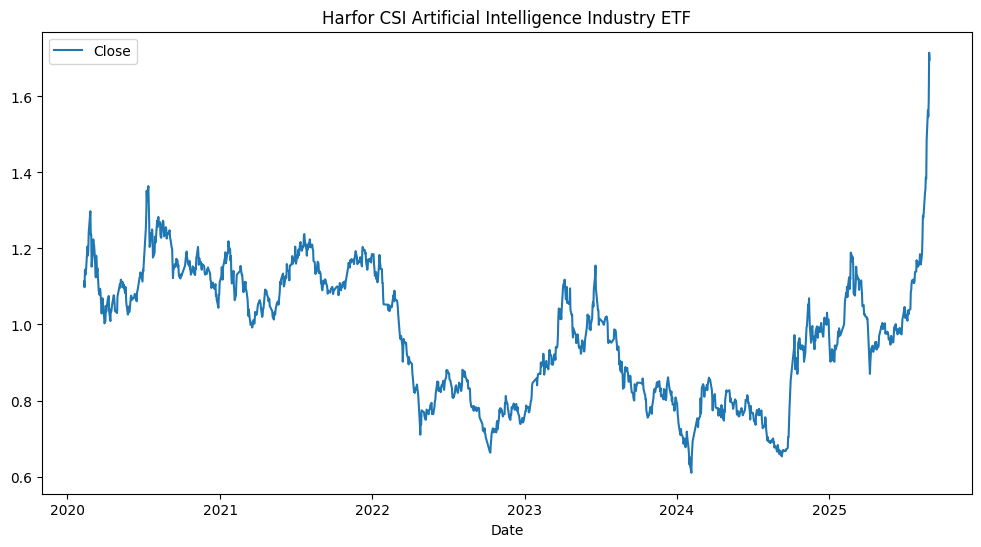

In [205]:
data.plot.line(y='Close',x='Date',figsize=(12,6),title='Harfor CSI Artificial Intelligence Industry ETF')

In [206]:
del data['Dividends']
del data["Stock Splits"]

In [207]:
data['Tomorrow'] = data["Close"].shift(-1)

In [208]:
data

,Date,Open,High,Low,Close,Volume,Tomorrow
0,2020-02-10,1.116,1.123,1.089,1.113,118079300,1.098
1,2020-02-11,1.114,1.119,1.090,1.098,24949100,1.144
2,2020-02-12,1.096,1.146,1.092,1.144,50270500,1.140
3,2020-02-13,1.143,1.154,1.124,1.140,60784000,1.132
4,2020-02-14,1.130,1.158,1.117,1.132,58584400,1.188
...,...,...,...,...,...,...,...
1324,2025-08-25,1.516,1.583,1.511,1.563,402639700,1.547
1325,2025-08-26,1.559,1.572,1.533,1.547,301443300,1.590
1326,2025-08-27,1.600,1.664,1.576,1.590,752718800,1.715
1327,2025-08-28,1.587,1.723,1.580,1.715,781722400,1.697


In [209]:
data['Target']=(data['Tomorrow']>data['Close']).astype(int)

In [210]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train=data.iloc[:-100]
test=data.iloc[-100:]

predictors=["Close","Volume","Open","High","Low"]
model.fit(train[predictors],train["Target"])


RandomForestClassifier(min_samples_split=100, random_state=1)

In [211]:
from sklearn.metrics import precision_score

preds=model.predict(test[predictors])

In [212]:
preds=pd.Series(preds,index=test.index)

In [213]:
precision_score(test["Target"],preds)

0.5

In [214]:
combined=pd.concat([test["Target"],preds],axis=1)

<Axes: >

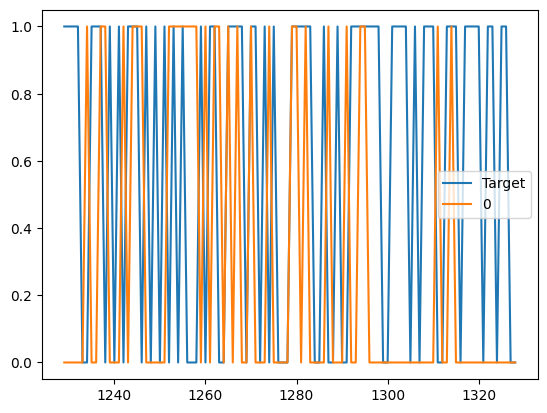

In [215]:
combined.plot()

In [216]:
def predict(train,test,predictors,model):
    model.fit(train[predictors],train["Target"])
    preds=model.predict(test[predictors])
    preds=pd.Series(preds,index=test.index,name="Predictions")
    combined=pd.concat([test["Target"],preds],axis=1)
    return combined

In [217]:
def backtest(data, model, predictors, start=100, step=20):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [218]:
predictions=backtest(data,model,predictors)

In [219]:
predictions["Predictions"].value_counts()

Predictions
0    744
1    485
Name: count, dtype: int64

In [220]:
precision_score(predictions["Target"],predictions["Predictions"])
predictions["Target"].value_counts() / predictions.shape[0]

Target
0    0.527258
1    0.472742
Name: count, dtype: float64

In [221]:
horizons = [2,5,20,60,250]
new_predictors = []

for horizon in horizons:
    rolling_averages = data[["Close"]].rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    data[ratio_column] = data["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    data[trend_column] = data["Target"].shift(1).rolling(horizon).sum()
    
    new_predictors += [ratio_column, trend_column]

In [222]:
data=data.dropna(subset=data.columns[data.columns != "Tomorrow"])


In [223]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=10, random_state=1)

In [224]:
def predict(train,test,predictors,model):
    model.fit(train[predictors],train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >= 0.6] = 1
    preds[preds < 0.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined


In [225]:
predictions = backtest(data,model,new_predictors)

In [226]:
predictions["Predictions"].value_counts()

Predictions
0.0    803
1.0    176
Name: count, dtype: int64

In [227]:
precision_score(predictions["Target"],predictions["Predictions"])

0.4715909090909091